In this notebook we will analyse the problems of the free water DTI model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

# To sample the diffusion-weighted directions
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

# To reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# To perform the monte-carlo simulations
from dipy.sims.voxel import multi_tensor

# To process DTI and free water DTI
import dipy.reconst.dti as dti
import dipy.reconst.fwdti as fwdti

Defining the acquisition parameters...

In [2]:
SNR = 15

# Sample 32 diffusion-weighted directions
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices # directions for each shell

# Create full dataset parameters
# (6 b-values = 0, 32 directions for each b-values 500 and 1500)
bvals = np.hstack((np.zeros(6), 500 * np.ones(n_pts), 1500 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))
gtab = gradient_table(bvals, bvecs)

Defining the ground truth values of tissue and water diffusion...

In [3]:
# free water component
VF = np.linspace(0, 100, num=11)
Dwater = 3e-3

# tissue component
FA = np.array([0.71, 0.30, 0.22, 0.11, 0.])
L1 = np.array([1.6e-3, 1.080e-3, 1.000e-3, 0.900e-3, 0.8e-03])
L2 = np.array([0.5e-3, 0.695e-3, 0.725e-3, 0.763e-3, 0.8e-03])
L3 = np.array([0.3e-3, 0.625e-3, 0.675e-3, 0.738e-3, 0.8e-03])

# simulations are repeated for 120 different diffusion tensor's
# directions (and each direction repeated 100 times)
nDTdirs = 120
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices # directions for each shell

nrep = 100  # number of repetitions for each direction

Generating simulations

In [4]:
DWI_simulates = np.empty((FA.size, VF.size, nrep * nDTdirs,
                          bvals.size))

for fa_i in range(FA.size):
    mevals = np.array([[L1[fa_i], L2[fa_i], L3[fa_i]],
                       [Dwater, Dwater, Dwater]])
    for vf_i in range(VF.size):
        fractions = [100 - VF[vf_i], VF[vf_i]]
        for di in range(nDTdirs):
            d = DTdirs[di]
            for s_i in np.arange(di * nrep, (di+1) * nrep):
                signal, sticks = multi_tensor(gtab, mevals,
                                              S0=100,
                                              angles=[d, (1, 0, 0)],
                                              fractions=fractions,
                                              snr=SNR)
                DWI_simulates[fa_i, vf_i, s_i, :] = signal
    prog = (fa_i+1.0) / FA.size * 100
    time.sleep(1)
    sys.stdout.write("\r%f%%" % prog)
    sys.stdout.flush()

100.000000%

Lets look to standard DTI

In [6]:
t0 = time.time()
dtimodel = dti.TensorModel(gtab, fit_method="NLLS")
dtifit = dtimodel.fit(DWI_simulates)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 283.523000 seconds to run


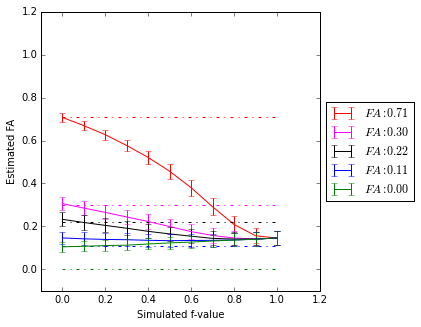

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

fa = dtifit.fa

median_fa = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

colors = {0: 'r', 1: 'magenta', 2: 'black', 3: 'b', 4: 'g'}

axs.set_ylim([-0.1, 1.2])
axs.set_xlim([-0.1, 1.2])
for fa_i in range(FA.size):
    for vf_i in range(VF.size):
        median_fa[vf_i] = np.median(fa[fa_i, vf_i, :])
        p25, p75 = np.percentile(fa[fa_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_fa[vf_i] - p25 
        upper_p[vf_i] = p75 - median_fa[vf_i]
    axs.plot(np.array([0., 1.]), FA[fa_i]*np.ones(2),
             ls='-.', c=colors[fa_i])
    axs.errorbar(VF/100, median_fa, fmt='-',
                       yerr=[lower_p, upper_p],
                       color=colors[fa_i],
                       ecolor=colors[fa_i],
                       linewidth=1.0,
                       label='$FA: %.2f$' % FA[fa_i])
axs.set_xlabel('Simulated f-value')
axs.set_ylabel('Estimated FA')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('dtiFA_vs_freewatercontamination_snr15.png', dpi=500)

Lets look to the wls DTI

In [17]:
t0 = time.time()
fwdtimodel = fwdti.FreeWaterTensorModel(gtab, fit_method="WLS")
fwdtifit = fwdtimodel.fit(DWI_simulates)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 684.635000 seconds to run


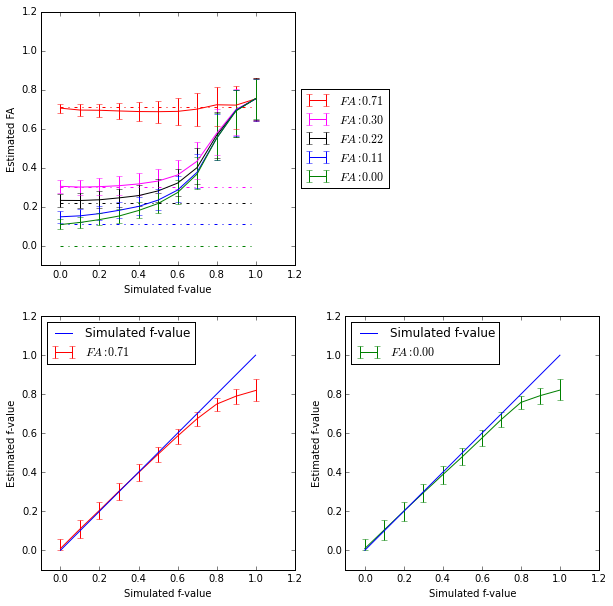

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

fa = fwdtifit.fa
f = fwdtifit.f

median_fa = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

colors = {0: 'r', 1: 'magenta', 2: 'black', 3: 'b', 4: 'g'}

axs[0, 0].set_ylim([-0.1, 1.2])
axs[0, 0].set_xlim([-0.1, 1.2])
for fa_i in range(FA.size):
    for vf_i in range(VF.size):
        median_fa[vf_i] = np.median(fa[fa_i, vf_i, :])
        p25, p75 = np.percentile(fa[fa_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_fa[vf_i] - p25 
        upper_p[vf_i] = p75 - median_fa[vf_i]
    axs[0, 0].plot(np.array([0., 1.]), FA[fa_i]*np.ones(2),
                   ls='-.', c=colors[fa_i])
    axs[0, 0].errorbar(VF/100, median_fa, fmt='-',
                       yerr=[lower_p, upper_p],
                       color=colors[fa_i],
                       ecolor=colors[fa_i],
                       linewidth=1.0,
                       label='$FA: %.2f$' % FA[fa_i])
axs[0, 0].set_xlabel('Simulated f-value')
axs[0, 0].set_ylabel('Estimated FA')
axs[0, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[0, 1].axis('off')

median_f = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

for idx, fa_i in enumerate([0, 4]):
    for vf_i in range(VF.size):
        median_f[vf_i] = np.median(f[fa_i, vf_i, :])
        p25, p75 = np.percentile(f[fa_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_f[vf_i] - p25 
        upper_p[vf_i] = p75 - median_f[vf_i]
    axs[1, idx].errorbar(VF/100, median_f, fmt='-',
                      yerr=[lower_p, upper_p],
                      color=colors[fa_i],
                      ecolor=colors[fa_i],
                      linewidth=1.0,
                      label='$FA: %.2f$' % FA[fa_i])
    # plot ground truth lines
    axs[1, idx].plot([0, 1], [0, 1], 'b', label = 'Simulated f-value')
    axs[1, idx].legend(loc='upper left')
    axs[1, idx].set_ylim([-0.1, 1.2])
    axs[1, idx].set_xlim([-0.1, 1.2])
    axs[1, idx].set_xlabel('Simulated f-value')
    axs[1, idx].set_ylabel('Estimated f-value')

fig.savefig('fwdti_simulations_wls_snr15.png', dpi=500)

Fitting the free water DTI model

In [22]:
t0 = time.time()
fwdtimodel = fwdti.FreeWaterTensorModel(gtab)
fwdtifit = fwdtimodel.fit(DWI_simulates)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 2890.643000 seconds to run


C:\Users\Rafael\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)


Compute FA and f-value statistics and save results

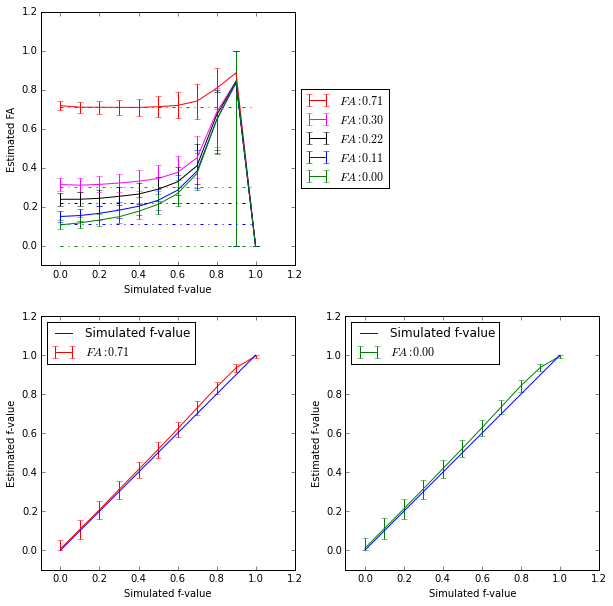

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

fa = fwdtifit.fa
f = fwdtifit.f

median_fa = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

colors = {0: 'r', 1: 'magenta', 2: 'black', 3: 'b', 4: 'g'}

axs[0, 0].set_ylim([-0.1, 1.2])
axs[0, 0].set_xlim([-0.1, 1.2])
for fa_i in range(FA.size):
    for vf_i in range(VF.size):
        median_fa[vf_i] = np.median(fa[fa_i, vf_i, :])
        p25, p75 = np.percentile(fa[fa_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_fa[vf_i] - p25 
        upper_p[vf_i] = p75 - median_fa[vf_i]
    axs[0, 0].plot(np.array([0., 1.]), FA[fa_i]*np.ones(2),
                   ls='-.', c=colors[fa_i])
    axs[0, 0].errorbar(VF/100, median_fa, fmt='-',
                       yerr=[lower_p, upper_p],
                       color=colors[fa_i],
                       ecolor=colors[fa_i],
                       linewidth=1.0,
                       label='$FA: %.2f$' % FA[fa_i])
axs[0, 0].set_xlabel('Simulated f-value')
axs[0, 0].set_ylabel('Estimated FA')
axs[0, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[0, 1].axis('off')

median_f = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

for idx, fa_i in enumerate([0, 4]):
    for vf_i in range(VF.size):
        median_f[vf_i] = np.median(f[fa_i, vf_i, :])
        p25, p75 = np.percentile(f[fa_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_f[vf_i] - p25 
        upper_p[vf_i] = p75 - median_f[vf_i]
    axs[1, idx].errorbar(VF/100, median_f, fmt='-',
                      yerr=[lower_p, upper_p],
                      color=colors[fa_i],
                      ecolor=colors[fa_i],
                      linewidth=1.0,
                      label='$FA: %.2f$' % FA[fa_i])
    # plot ground truth lines
    axs[1, idx].plot([0, 1], [0, 1], 'b', label = 'Simulated f-value')
    axs[1, idx].legend(loc='upper left')
    axs[1, idx].set_ylim([-0.1, 1.2])
    axs[1, idx].set_xlim([-0.1, 1.2])
    axs[1, idx].set_xlabel('Simulated f-value')
    axs[1, idx].set_ylabel('Estimated f-value')

fig.savefig('fwdti_simulations_nls_snr15.png', dpi=500)

Done